# Evaluating Transformer-based Models for Sentiment Analysis on the SST-2 Datas

## Table of Contents
* [EDA](##EDA)
    * [Distribution of Labels](###Distribution_of_Labels¶)
    * [Distribution of Sentence Lengths](###Distribution_of_Sentence_Lengths¶)
    * [Class Distribution](###Class_Distribution¶)
    * [Word Cloud](###Word_Cloud¶)
* [Models](#Models)
    * [BERT](##BERT)
        * [Data Processing](##Data_Processing)
        * [Train Model](##Train-Model)
        * [Prediction](###Prediction)
    * [Distilbert](##DistilbertT)
        * [Data Processing](##Data_Processing)
        * [Train Model](##Train-Model)
        * [Prediction](###Prediction)
    * [Electra](##Electra)
        * [Data Processing](##Data_Processing)
        * [Train Model](##Train-Model)
        * [Prediction](###Prediction)
    * [Roberta](##Roberta)
        * [Data Processing](##Data_Processing)
        * [Train Model](##Train-Model)
        * [Prediction](###Prediction)
    * [Albert](##Albert)
        * [Data Processing](##Data_Processing)
        * [Train Model](##Train-Model)
        * [Prediction](###Prediction)
* [Comparision](##Comparision)
    * [Accuracy Comparison](###Accuracy_Comparison)
    * [F1, Precision, and Recall Comparison](###F1,_Precision,_and_Recall_Comparison)
    * [Loss Comparison](###Loss_Comparison)


## EDA

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
import pandas as pd

from sklearn.metrics import accuracy_score

In [ ]:
# Load the dataset
dataset = load_dataset("glue", "sst2")

Generating train split:   0%|          | 0/8551 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1043 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1063 [00:00<?, ? examples/s]

### Distribution of Labels

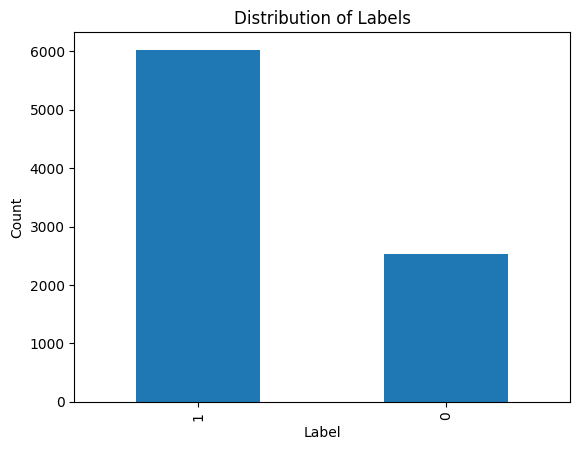

In [ ]:
# Get the train split
import matplotlib.pyplot as plt
train_dataset = dataset["train"]


# Convert the train split to a pandas DataFrame
df = pd.DataFrame(train_dataset)

# Distribution of labels
label_counts = df["label"].value_counts()
label_counts.plot(kind="bar")
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Distribution of Labels")
plt.show()

### Distribution of Sentence Lengths

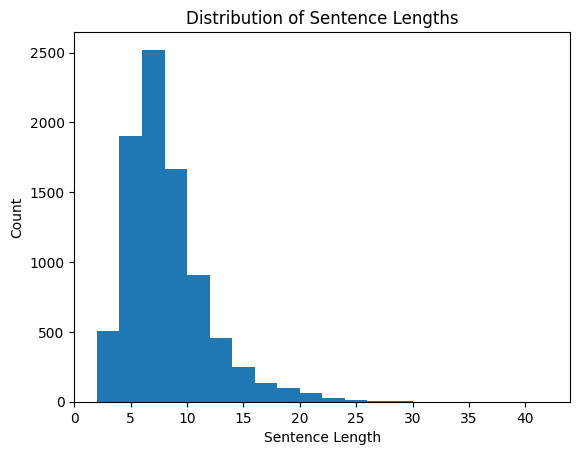

In [ ]:
# Sentence length analysis
df["sentence_length"] = df["sentence"].apply(lambda x: len(x.split()))
plt.hist(df["sentence_length"], bins=20)
plt.xlabel("Sentence Length")
plt.ylabel("Count")
plt.title("Distribution of Sentence Lengths")
plt.show()

### Class Distribution

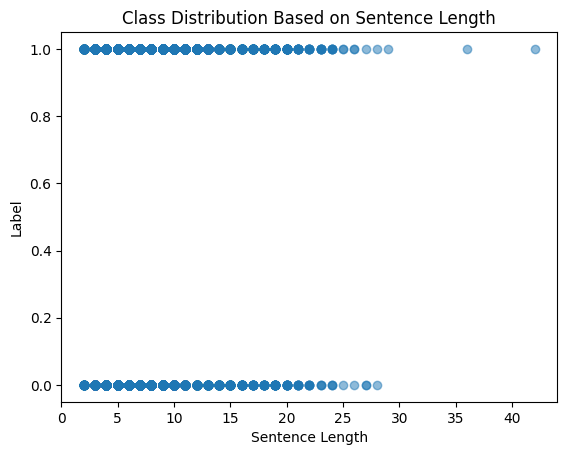

In [ ]:
# Class distribution based on sentence length
plt.scatter(df["sentence_length"], df["label"], alpha=0.5)
plt.xlabel("Sentence Length")
plt.ylabel("Label")
plt.title("Class Distribution Based on Sentence Length")
plt.show()

### Word Cloud

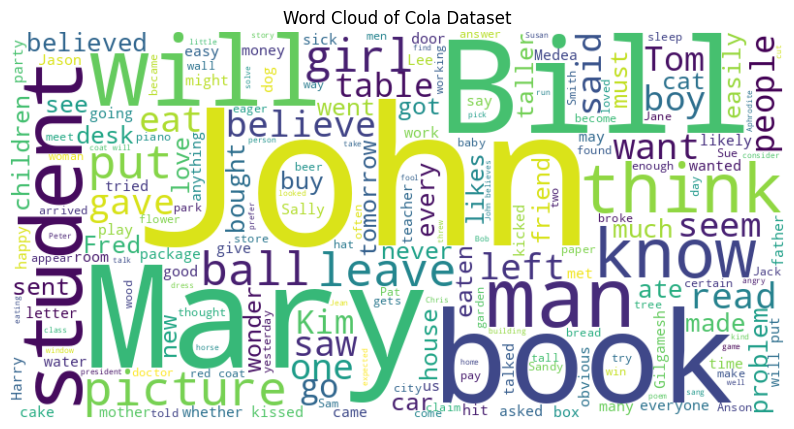

In [ ]:
from wordcloud import WordCloud

# Concatenate all sentences into a single string
all_sentences = " ".join(df["sentence"].tolist())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_sentences)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Cola Dataset")
plt.show()


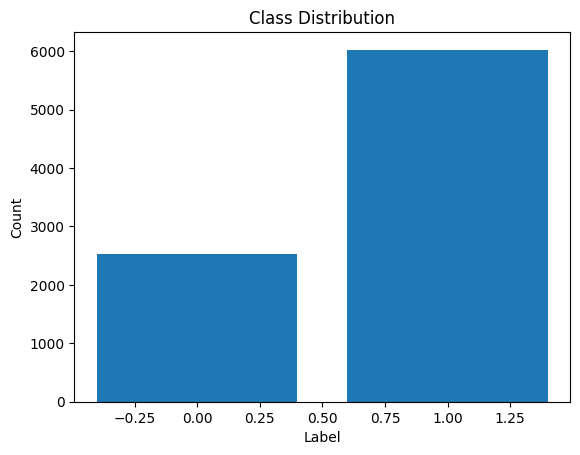

In [ ]:
label_counts = df["label"].value_counts()

plt.bar(label_counts.index, label_counts.values)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.show()


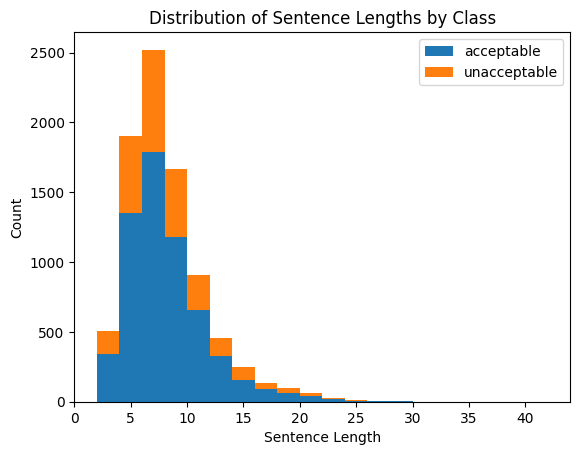

In [ ]:
positive_sentences = df[df["label"] == 1]["sentence_length"]
negative_sentences = df[df["label"] == 0]["sentence_length"]

plt.hist([positive_sentences, negative_sentences], bins=20, stacked=True, label=["acceptable", "unacceptable"])
plt.xlabel("Sentence Length")
plt.ylabel("Count")
plt.title("Distribution of Sentence Lengths by Class")
plt.legend()
plt.show()


# Models

## BERT
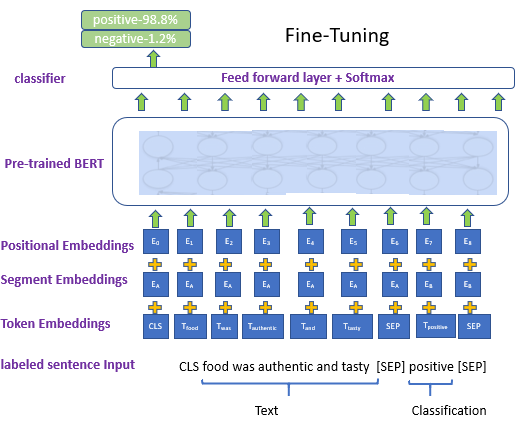

## Data Processing

In [ ]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the sentences and add special tokens
def tokenize_function(examples):
    return tokenizer(examples["sentence"], truncation=True, padding="max_length")

# Apply tokenization to the dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Set the format to PyTorch tensors
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/8551 [00:00<?, ? examples/s]

Map:   0%|          | 0/1043 [00:00<?, ? examples/s]

Map:   0%|          | 0/1063 [00:00<?, ? examples/s]

In [ ]:
# Split the dataset into training and testing subsets
train_size = 0.8
train_dataset = tokenized_dataset["train"].select(range(int(len(tokenized_dataset["train"]) * train_size)))
val_dataset = tokenized_dataset["train"].select(range(int(len(tokenized_dataset["train"]) * train_size), len(tokenized_dataset["train"])))



## Train Model

In [ ]:
# Load the pre-trained BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Define the training arguments
training_args = TrainingArguments(
    output_dir="./output_dir",  # Directory where the model checkpoints and logs will be saved # Evaluate the model after each epoch
    evaluation_strategy = "steps",
    per_device_train_batch_size=26,
    per_device_eval_batch_size=26,
    save_total_limit=1,
    eval_steps =300,
    logging_steps=300,
    num_train_epochs=1,
    logging_dir="./logs",  # Directory where the training logs will be saved
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Start the training
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Prediction

In [ ]:
test_data = tokenized_dataset["validation"]
test_input = test_data['input_ids']
y_true = test_data['label']


In [ ]:


from torch.utils.data import DataLoader

# Create a DataLoader for batch processing
batch_size = 16  # Adjust batch size based on available memory
test_loader = DataLoader(test_data, batch_size=batch_size)

ypred = []
trainer.model.eval()

for batch in tqdm(test_loader):
    input_ids = batch['input_ids'].to(trainer.model.device)
    attention_mask = batch['attention_mask'].to(trainer.model.device)

    with torch.no_grad():
        outputs = trainer.model(input_ids=input_ids, attention_mask=attention_mask)

    pred_labels = outputs.logits.argmax(dim=1).tolist()
    ypred.extend(pred_labels)




100%|██████████| 55/55 [00:07<00:00,  7.05it/s]


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("accuracy_score: ", accuracy_score(y_true, ypred))
print("f1_score: ", f1_score(y_true, ypred))
print("precision_score: ", precision_score(y_true, ypred))
print("recall_score: ", recall_score(y_true, ypred))

accuracy_score:  0.9231651376146789
f1_score:  0.9251396648044693
precision_score:  0.917960088691796
recall_score:  0.9324324324324325


In [ ]:
import pandas as pd



# Convert lists to a DataFrame
result = {'Truth value': y_true, 'Predict value': ypred}
df = pd.DataFrame(result)

# Save the DataFrame to a CSV file
df.to_csv('predictions_bert.csv', index=False)

In [ ]:
df

,Truth value,Predict value
0,1,1
1,0,0
2,1,1
3,1,1
4,0,0
...,...,...
867,0,0
868,1,1
869,0,0
870,0,0


## Distilbert
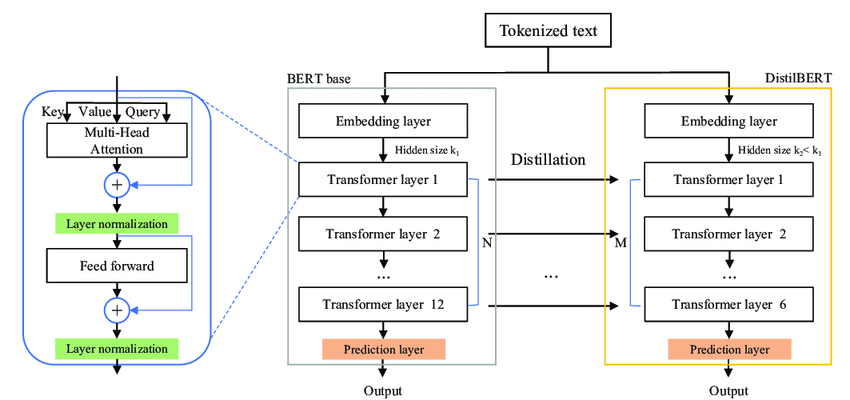

## Data Processing

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score

# Load the SST-2 dataset
dataset = load_dataset("glue", "sst2")

# Load the DistilBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)


# Tokenize the sentences and add special tokens
def tokenize_function(examples):
    return tokenizer(examples["sentence"], truncation=True, padding="max_length")

# Apply tokenization to the dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Set the format to PyTorch tensors
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])



Found cached dataset glue (C:/Users/Kowsher/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
100%|██████████| 3/3 [00:00<00:00, 999.91it/s]
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some wei

In [ ]:
# Split the dataset into training and testing subsets
train_size = 0.8
train_dataset = tokenized_dataset["train"].select(range(int(len(dataset["train"]) * train_size)))
val_dataset = tokenized_dataset["train"].select(range(int(len(dataset["train"]) * train_size), len(dataset["train"])))

## Train Model

In [ ]:
# Define the training and evaluation metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}


# Define the training arguments
training_args = TrainingArguments(
    output_dir="./output_dir_distilbert",  # Directory where the model checkpoints and logs will be saved # Evaluate the model after each epoch
    evaluation_strategy = "steps",
    per_device_train_batch_size=21,
    per_device_eval_batch_size=21,
    save_total_limit=1,
    eval_steps =300,
    logging_steps=300,
    num_train_epochs=1,
    logging_dir="./logs",  # Directory where the training logs will be saved
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()



C:\Users\Kowsher\anaconda3\envs\pytorch_env\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
300,0.363900,0.269613,0.891908
600,0.272100,0.243999,0.907127
900,0.231500,0.223741,0.914180
1200,0.226700,0.221039,0.921084
1500,0.208900,0.185889,0.931552
1800,0.195600,0.176208,0.934373
2100,0.166700,0.183892,0.937342
2400,0.183800,0.172530,0.939569


TrainOutput(global_step=2566, training_loss=0.2264335220527203, metrics={'train_runtime': 1047.6592, 'train_samples_per_second': 51.428, 'train_steps_per_second': 2.449, 'total_flos': 7137210972186624.0, 'train_loss': 0.2264335220527203, 'epoch': 1.0})

## Prediction

In [ ]:
test_data = tokenized_dataset["validation"]
test_input = test_data['input_ids']
y_true = test_data['label']


In [ ]:


from torch.utils.data import DataLoader

# Create a DataLoader for batch processing
batch_size = 16  # Adjust batch size based on available memory
test_loader = DataLoader(test_data, batch_size=batch_size)

ypred = []
trainer.model.eval()

for batch in tqdm(test_loader):
    input_ids = batch['input_ids'].to(trainer.model.device)
    attention_mask = batch['attention_mask'].to(trainer.model.device)

    with torch.no_grad():
        outputs = trainer.model(input_ids=input_ids, attention_mask=attention_mask)

    pred_labels = outputs.logits.argmax(dim=1).tolist()
    ypred.extend(pred_labels)




100%|██████████| 55/55 [00:04<00:00, 11.52it/s]


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("accuracy_score: ", accuracy_score(y_true, ypred))
print("f1_score: ", f1_score(y_true, ypred))
print("precision_score: ", precision_score(y_true, ypred))
print("recall_score: ", recall_score(y_true, ypred))

accuracy_score:  0.9071100917431193
f1_score:  0.9108910891089109
precision_score:  0.8903225806451613
recall_score:  0.9324324324324325


In [ ]:
import pandas as pd



# Convert lists to a DataFrame
result = {'Truth value': y_true, 'Predict value': ypred}
df = pd.DataFrame(result)

# Save the DataFrame to a CSV file
df.to_csv('predictions_distilbert.csv', index=False)

In [ ]:
df

,Truth value,Predict value
0,1,1
1,0,0
2,1,1
3,1,1
4,0,0
...,...,...
867,0,0
868,1,1
869,0,0
870,0,0


## Electra
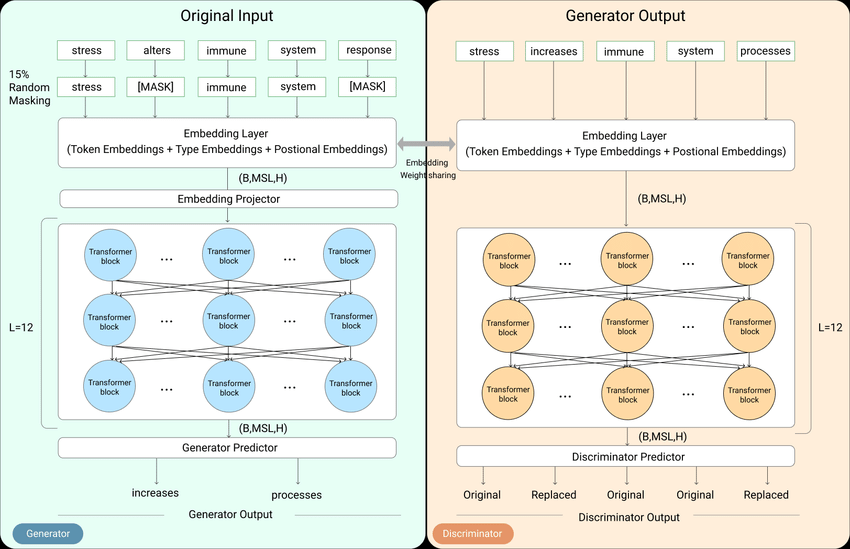

## Data Processing

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score

# Load the SST-2 dataset
dataset = load_dataset("glue", "sst2")

# Load the ELECTRA tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("google/electra-base-discriminator")
model = AutoModelForSequenceClassification.from_pretrained("google/electra-base-discriminator", num_labels=2)


Found cached dataset glue (C:/Users/Kowsher/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
100%|██████████| 3/3 [00:00<00:00, 1000.31it/s]
C:\Users\Kowsher\anaconda3\envs\pytorch_env\lib\site-packages\huggingface_hub\file_download.py:129: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Kowsher\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/app

In [ ]:
# Tokenize the sentences and add special tokens
def tokenize_function(examples):
    return tokenizer(examples["sentence"], truncation=True, padding="max_length")

# Apply tokenization to the dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Set the format to PyTorch tensors
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

In [ ]:
# Split the dataset into training and testing subsets
train_size = 0.8
train_dataset = tokenized_dataset["train"].select(range(int(len(dataset["train"]) * train_size)))
val_dataset = tokenized_dataset["train"].select(range(int(len(dataset["train"]) * train_size), len(dataset["train"])))

## Train Model

In [ ]:
# Define the training and evaluation metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}


# Define the training arguments
training_args = TrainingArguments(
    output_dir="./output_dir_electra",  # Directory where the model checkpoints and logs will be saved # Evaluate the model after each epoch
    evaluation_strategy = "steps",
    per_device_train_batch_size=21,
    per_device_eval_batch_size=21,
    save_total_limit=1,
    eval_steps =300,
    logging_steps=300,
    num_train_epochs=1,
    logging_dir="./logs",  # Directory where the training logs will be saved
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()



C:\Users\Kowsher\anaconda3\envs\pytorch_env\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
300,0.325000,0.227240,0.922866
600,0.239900,0.266585,0.911656
900,0.224000,0.194780,0.935041
1200,0.206600,0.178266,0.939124
1500,0.186600,0.169012,0.944246
1800,0.183100,0.156087,0.942910
2100,0.152300,0.161690,0.950408
2400,0.157400,0.148417,0.950260


TrainOutput(global_step=2566, training_loss=0.20486601534432392, metrics={'train_runtime': 2060.4748, 'train_samples_per_second': 26.149, 'train_steps_per_second': 1.245, 'total_flos': 1.417616055174144e+16, 'train_loss': 0.20486601534432392, 'epoch': 1.0})

## Prediction

In [ ]:
test_data = tokenized_dataset["validation"]
test_input = test_data['input_ids']
y_true = test_data['label']




from torch.utils.data import DataLoader

# Create a DataLoader for batch processing
batch_size = 16  # Adjust batch size based on available memory
test_loader = DataLoader(test_data, batch_size=batch_size)

ypred = []
trainer.model.eval()

for batch in tqdm(test_loader):
    input_ids = batch['input_ids'].to(trainer.model.device)
    attention_mask = batch['attention_mask'].to(trainer.model.device)

    with torch.no_grad():
        outputs = trainer.model(input_ids=input_ids, attention_mask=attention_mask)

    pred_labels = outputs.logits.argmax(dim=1).tolist()
    ypred.extend(pred_labels)




100%|██████████| 55/55 [00:07<00:00,  6.97it/s]


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("accuracy_score: ", accuracy_score(y_true, ypred))
print("f1_score: ", f1_score(y_true, ypred))
print("precision_score: ", precision_score(y_true, ypred))
print("recall_score: ", recall_score(y_true, ypred))

accuracy_score:  0.944954128440367
f1_score:  0.945823927765237
precision_score:  0.9479638009049773
recall_score:  0.9436936936936937


In [ ]:
import pandas as pd



# Convert lists to a DataFrame
result = {'Truth value': y_true, 'Predict value': ypred}
df = pd.DataFrame(result)

# Save the DataFrame to a CSV file
df.to_csv('predictions_electra.csv', index=False)

## Roberta
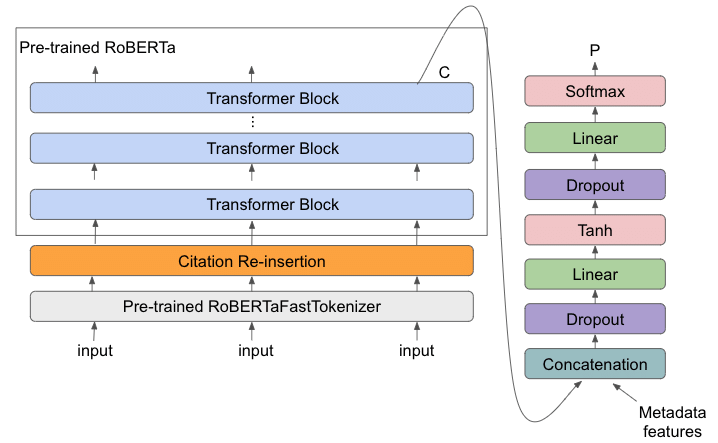

## Data Processing

In [ ]:
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score

# Load the SST-2 dataset
dataset = load_dataset("glue", "sst2")

# Load the RoBERTa tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)


Found cached dataset glue (C:/Users/Kowsher/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
100%|██████████| 3/3 [00:00<00:00, 1002.62it/s]
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequen

In [ ]:
# Tokenize the sentences and add special tokens
def tokenize_function(examples):
    return tokenizer(examples["sentence"], truncation=True, padding="max_length")

# Apply tokenization to the dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Set the format to PyTorch tensors
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

In [ ]:
# Split the dataset into training and testing subsets
train_size = 0.8
train_dataset = tokenized_dataset["train"].select(range(int(len(dataset["train"]) * train_size)))
val_dataset = tokenized_dataset["train"].select(range(int(len(dataset["train"]) * train_size), len(dataset["train"])))

## Train Model

In [ ]:
# Define the training and evaluation metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}


# Define the training arguments
training_args = TrainingArguments(
    output_dir="./output_dir_roberta",  # Directory where the model checkpoints and logs will be saved # Evaluate the model after each epoch
    evaluation_strategy = "steps",
    per_device_train_batch_size=21,
    per_device_eval_batch_size=21,
    save_total_limit=1,
    eval_steps =300,
    logging_steps=300,
    num_train_epochs=1,
    logging_dir="./logs",  # Directory where the training logs will be saved
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()



C:\Users\Kowsher\anaconda3\envs\pytorch_env\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
300,0.419800,0.311034,0.874091
600,0.312300,0.274874,0.897550
900,0.284300,0.270034,0.892799
1200,0.266100,0.231328,0.918857
1500,0.256800,0.235818,0.923385
1800,0.219900,0.202456,0.928805
2100,0.190400,0.213599,0.932442
2400,0.201300,0.187958,0.932442


TrainOutput(global_step=2566, training_loss=0.2632638094300696, metrics={'train_runtime': 2064.9397, 'train_samples_per_second': 26.092, 'train_steps_per_second': 1.243, 'total_flos': 1.417616055174144e+16, 'train_loss': 0.2632638094300696, 'epoch': 1.0})

## Prediction

In [ ]:
test_data = tokenized_dataset["validation"]
test_input = test_data['input_ids']
y_true = test_data['label']




from torch.utils.data import DataLoader

# Create a DataLoader for batch processing
batch_size = 16  # Adjust batch size based on available memory
test_loader = DataLoader(test_data, batch_size=batch_size)

ypred = []
trainer.model.eval()

for batch in tqdm(test_loader):
    input_ids = batch['input_ids'].to(trainer.model.device)
    attention_mask = batch['attention_mask'].to(trainer.model.device)

    with torch.no_grad():
        outputs = trainer.model(input_ids=input_ids, attention_mask=attention_mask)

    pred_labels = outputs.logits.argmax(dim=1).tolist()
    ypred.extend(pred_labels)




100%|██████████| 55/55 [00:06<00:00,  8.39it/s]


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("accuracy_score: ", accuracy_score(y_true, ypred))
print("f1_score: ", f1_score(y_true, ypred))
print("precision_score: ", precision_score(y_true, ypred))
print("recall_score: ", recall_score(y_true, ypred))

accuracy_score:  0.9254587155963303
f1_score:  0.9272116461366182
precision_score:  0.9220489977728286
recall_score:  0.9324324324324325


In [ ]:
import pandas as pd



# Convert lists to a DataFrame
result = {'Truth value': y_true, 'Predict value': ypred}
df = pd.DataFrame(result)

# Save the DataFrame to a CSV file
df.to_csv('predictions_roberta.csv', index=False)

## Albert
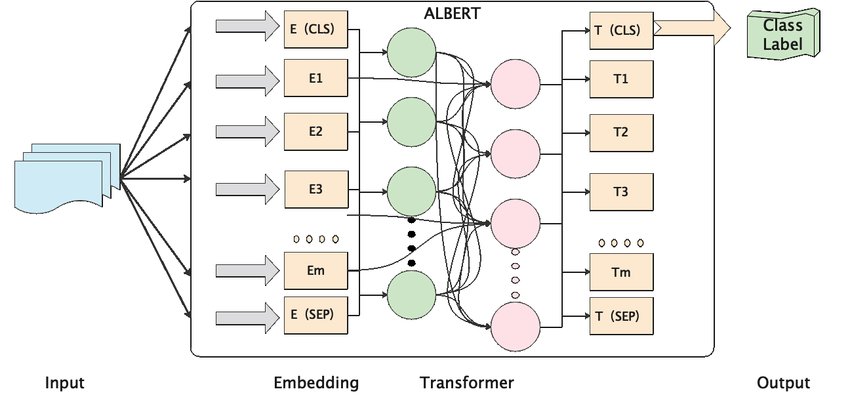

## Data Processing

In [ ]:
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score

# Load the SST-2 dataset
dataset = load_dataset("glue", "sst2")

# Load the RoBERTa tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")
model = AutoModelForSequenceClassification.from_pretrained("albert-base-v2", num_labels=2)


Found cached dataset glue (C:/Users/Kowsher/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
100%|██████████| 3/3 [00:00<00:00, 749.92it/s]
Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.dense.weight', 'predictions.decoder.weight', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.decoder.bias', 'predictions.dense.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassifica

In [ ]:
# Tokenize the sentences and add special tokens
def tokenize_function(examples):
    return tokenizer(examples["sentence"], truncation=True, padding="max_length")

# Apply tokenization to the dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Set the format to PyTorch tensors
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

In [ ]:
# Split the dataset into training and testing subsets
train_size = 0.8
train_dataset = tokenized_dataset["train"].select(range(int(len(dataset["train"]) * train_size)))
val_dataset = tokenized_dataset["train"].select(range(int(len(dataset["train"]) * train_size), len(dataset["train"])))

## Train Model

In [ ]:
# Define the training and evaluation metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}


# Define the training arguments
training_args = TrainingArguments(
    output_dir="./output_dir_albert",  # Directory where the model checkpoints and logs will be saved # Evaluate the model after each epoch
    evaluation_strategy = "steps",
    per_device_train_batch_size=21,
    per_device_eval_batch_size=21,
    save_total_limit=1,
    eval_steps =300,
    logging_steps=300,
    num_train_epochs=1,
    logging_dir="./logs",  # Directory where the training logs will be saved
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()



Step,Training Loss,Validation Loss,Accuracy
300,0.691300,0.687774,0.555902
600,0.686600,0.692888,0.555902
900,0.688800,0.688369,0.555902
1200,0.669200,0.623932,0.719673
1500,0.524500,0.446639,0.816258
1800,0.409500,0.363404,0.847958
2100,0.364300,0.348731,0.855754
2400,0.341600,0.334938,0.861024


TrainOutput(global_step=2566, training_loss=0.5332555153921815, metrics={'train_runtime': 2232.9144, 'train_samples_per_second': 24.129, 'train_steps_per_second': 1.149, 'total_flos': 1287605824727040.0, 'train_loss': 0.5332555153921815, 'epoch': 1.0})

## Prediction

In [ ]:
test_data = tokenized_dataset["validation"]
test_input = test_data['input_ids']
y_true = test_data['label']




from torch.utils.data import DataLoader

# Create a DataLoader for batch processing
batch_size = 16  # Adjust batch size based on available memory
test_loader = DataLoader(test_data, batch_size=batch_size)

ypred = []
trainer.model.eval()

for batch in tqdm(test_loader):
    input_ids = batch['input_ids'].to(trainer.model.device)
    attention_mask = batch['attention_mask'].to(trainer.model.device)

    with torch.no_grad():
        outputs = trainer.model(input_ids=input_ids, attention_mask=attention_mask)

    pred_labels = outputs.logits.argmax(dim=1).tolist()
    ypred.extend(pred_labels)




100%|██████████| 55/55 [00:09<00:00,  6.10it/s]


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("accuracy_score: ", accuracy_score(y_true, ypred))
print("f1_score: ", f1_score(y_true, ypred))
print("precision_score: ", precision_score(y_true, ypred))
print("recall_score: ", recall_score(y_true, ypred))

accuracy_score:  0.8073394495412844
f1_score:  0.8086560364464692
precision_score:  0.8179723502304147
recall_score:  0.7995495495495496


In [ ]:
import pandas as pd



# Convert lists to a DataFrame
result = {'Truth value': y_true, 'Predict value': ypred}
df = pd.DataFrame(result)

# Save the DataFrame to a CSV file
df.to_csv('predictions_albert.csv', index=False)

## Comparision

### Accuracy Comparison

In [ ]:
import matplotlib.pyplot as plt

models = ["BERT", "DistilBERT", "ELECTRA", "RoBERTa", "ALBERT"]
accuracy_val = [0.924, 0.935, 0.950, 0.932, 0.861]
accuracy_test = [0.923, 0.907, 0.945, 0.925, 0.807]
f1_score = [0.925, 0.910, 0.945, 0.927, 0.808]
precision = [0.917, 0.890, 0.948, 0.922, 0.817]
recall = [0.933, 0.932, 0.944, 0.932, 0.878]
loss_val = [0.161, 0.183, 0.157, 0.201, 0.349]
loss_train = [0.158, 0.172, 0.148, 0.188, 0.334]



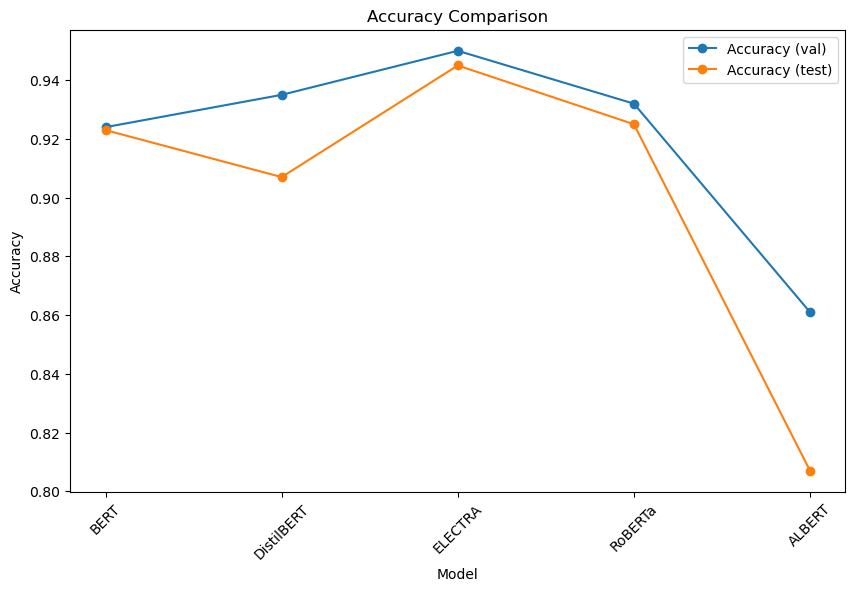

In [ ]:
# Plotting accuracy
plt.figure(figsize=(10, 6))
plt.plot(models, accuracy_val, marker="o", label="Accuracy (val)")
plt.plot(models, accuracy_test, marker="o", label="Accuracy (test)")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison")
plt.legend()
plt.xticks(rotation=45)
plt.show()




### F1, Precision, and Recall Comparison

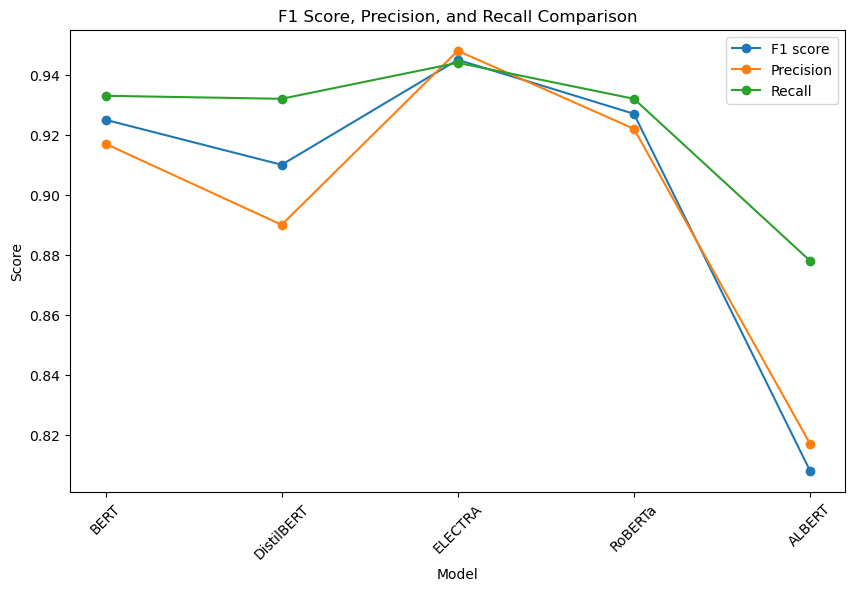

In [ ]:
# Plotting F1 score, precision, and recall
plt.figure(figsize=(10, 6))
plt.plot(models, f1_score, marker="o", label="F1 score")
plt.plot(models, precision, marker="o", label="Precision")
plt.plot(models, recall, marker="o", label="Recall")
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("F1 Score, Precision, and Recall Comparison")
plt.legend()
plt.xticks(rotation=45)
plt.show()



### Loss Comparison

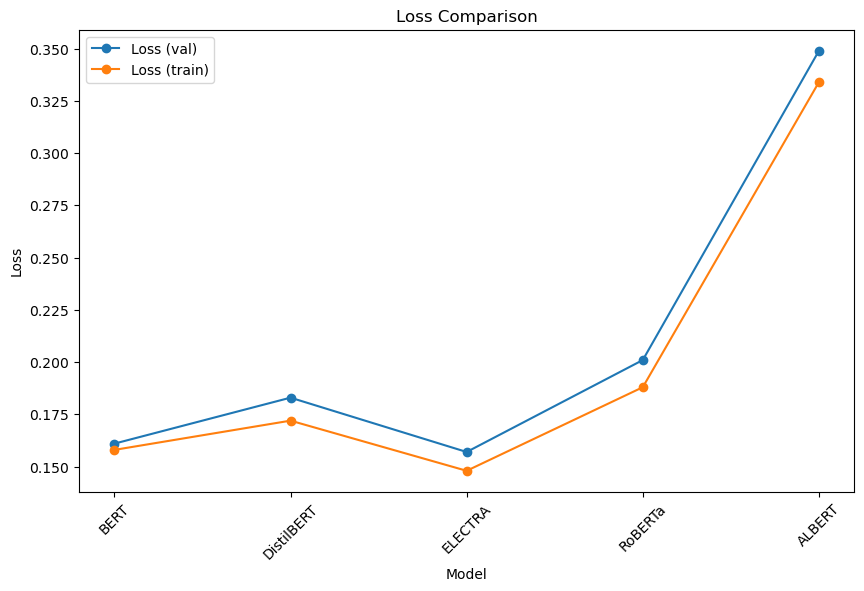

In [ ]:
# Plotting loss
plt.figure(figsize=(10, 6))
plt.plot(models, loss_val, marker="o", label="Loss (val)")
plt.plot(models, loss_train, marker="o", label="Loss (train)")
plt.xlabel("Model")
plt.ylabel("Loss")
plt.title("Loss Comparison")
plt.legend()
plt.xticks(rotation=45)
plt.show()